## Notebook to create a Hybrid Hydrological Model

**Description**

The following notebook contains the code to create, train, validate and test a Hybrid Hydrological Model 
using a LSTM network plus a process based rainfall-runoff model. The code allows for the creation of single-basin 
models, but it is conceptualized to create regional models. The code is intended as an intial introduction to the topic, 
in which we prioritized interpretability over modularity.

The logic of the code is heavily based on [Neural Hydrology](https://doi.org/10.21105/joss.04050)[1]. For a more 
flexible, robust and modular implementation of deep learning method in hydrological modeling we advice the use of Neural 
Hydrology. 

**Authors:**
- Eduardo Acuna Espinoza (eduardo.espinoza@kit.edu)
- Ralf Loritz
- Manuel Álvarez Chaves

**References:**

[1]: "F. Kratzert, M. Gauch, G. Nearing and D. Klotz: NeuralHydrology -- A Python library for Deep Learning research in hydrology. Journal of Open Source Software, 7, 4050, doi: 10.21105/joss.04050, 2022"

In [1]:
#Import necessary packages
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

sys.path.append("../aux_functions")
sys.path.append("../datasetzoo")
sys.path.append("../modelzoo")

# Import classes and functions from other files
from functions_training import weighted_rmse, nse_basin_averaged
from functions_evaluation import nse
from functions_aux import create_folder, set_random_seed, write_report

# Import dataset to use
from camelsgb import CAMELS_GB

# Import classes that will be used to create the models
from shm import SHM as conceptual_model
from hybrid import Hybrid as hybrid_hydrological_model

Part 1. Initialize information

In [2]:
# paths to access the information
path_entities = '../../data/basin_id/basins_camels_gb_669.txt'
path_data = '../../data/CAMELS_GB'

# dynamic forcings and target
dynamic_input = ['precipitation', 'peti', 'temperature']
conceptual_input = ['precipitation', 'peti', 'temperature']
target = ['discharge_spec']

# static attributes that will be used
static_input = ['area',
                'elev_mean',
                'dpsbar',
                'sand_perc',
                'silt_perc',
                'clay_perc',
                'porosity_hypres',
                'conductivity_hypres',
                'soil_depth_pelletier',
                'dwood_perc',
                'ewood_perc',
                'crop_perc',
                'urban_perc',
                'reservoir_cap',
                'p_mean',
                'pet_mean',
                'p_seasonality',
                'frac_snow',
                'high_prec_freq',
                'low_prec_freq',
                'high_prec_dur',
                'low_prec_dur']

# time periods
training_period = ['1980-10-01','1997-12-31']
validation_period = ['1975-10-01','1980-09-30']
testing_period = ['1998-01-01','2008-12-31']

model_hyper_parameters = {
  'input_size_lstm': len(dynamic_input) + len(static_input),
  'no_of_layers': 1,
  'seq_length': 730,
  'predict_last_n': 365,
  'hidden_size': 64,
  'batch_size': 256,
  'no_of_epochs': 20,
  'max_updates_per_epoch': 450,
  'learning_rate': 0.001,
  'set_forget_gate': 3.0,
  'n_conceptual_models': 1,
  'parameter_type': {'dd':'dynamic', 'f_thr':'dynamic', 'sumax':'dynamic', 'beta':'dynamic', 'perc':'dynamic', 
                     'kf':'dynamic', 'ki':'dynamic', 'kb':'dynamic', }
                     }

# device
running_device = 'gpu' #cpu or gpu

# define seed
seed = 42

# Name of the folder where the results will be stored (the folder must be created before running
# the code)
path_save_folder = '../results/models/LSTM_SHM_GB_669_v3'

# colorblind friendly palette for plotting
color_palette = {'observed': '#1f78b4','simulated': '#ff7f00'}

In [3]:
# Create folder to store the results
create_folder(folder_path=path_save_folder)

Folder '../results/models/LSTM_SHM_GB_669_v3' already exists.


Part 2. Create the different datasets and dataloaders

In [4]:
# Dataset training
training_dataset = CAMELS_GB(dynamic_input= dynamic_input,
                             target= target, 
                             sequence_length= model_hyper_parameters['seq_length'],
                             time_period= training_period,
                             path_data= path_data,
                             path_entities= path_entities,
                             predict_last_n= model_hyper_parameters['predict_last_n'],
                             static_input= static_input,
                             conceptual_input= conceptual_input,
                             check_NaN= True)

training_dataset.calculate_basin_std()
training_dataset.calculate_global_statistics() # the global statistics are calculated in the training period!
training_dataset.standardize_data(standardize_output=False)

In [5]:
# Dataloader training
train_loader = DataLoader(training_dataset, 
                          batch_size=model_hyper_parameters['batch_size'],
                          shuffle=True,
                          drop_last = True)

print('Batches in training: ', len(train_loader))
sample = next(iter(train_loader))
print(f'x_lstm: {sample['x_lstm'].shape} | x_conceptual: {sample['x_conceptual'].shape} | y_obs: {sample['y_obs'].shape} | basin_std: {sample['basin_std'].shape}')

Batches in training:  14331
x_lstm: torch.Size([256, 730, 25]) | x_conceptual: torch.Size([256, 730, 3]) | y_obs: torch.Size([256, 365, 1]) | basin_std: torch.Size([256, 365, 1])


Part 3. Define model

In [6]:
# check if model will be run in gpu or cpu
if running_device == 'gpu':
    print(torch.cuda.get_device_name(0))
    device= f'cuda:0'
elif running_device == 'cpu':
    device = "cpu"

# set random seed
set_random_seed(seed=seed)

# construct model
hybrid_model = hybrid_hydrological_model(hyperparameters=model_hyper_parameters, 
                                         conceptual_model = conceptual_model).to(device)

Tesla V100-SXM2-16GB


Part 6. Train LSTM

In [ ]:
# optimizer: Adam, learning rate, weight decay
optimizer = torch.optim.Adam(hybrid_model.parameters(), lr = model_hyper_parameters["learning_rate"])

# set forget gate to 3 to ensure that the model is capable to learn long term dependencies
hybrid_model.lstm.bias_hh_l0.data[model_hyper_parameters['hidden_size']:2 * model_hyper_parameters['hidden_size']] = model_hyper_parameters["set_forget_gate"]

training_time = time.time()
for epoch in range(model_hyper_parameters["no_of_epochs"]):

    epoch_start_time = time.time()
    total_loss = []
    # Training ----------------------------------------------------------------------
    hybrid_model.train()
    for idx, sample in enumerate(train_loader): 
        # maximum iterations per epoch
        if idx >= model_hyper_parameters['max_updates_per_epoch']: break
        
        optimizer.zero_grad() # sets gradients of weigths and bias to zero
        pred = hybrid_model(x_lstm= sample['x_lstm'].to(device), 
                            x_conceptual= sample['x_conceptual'].to(device)) # forward call
        
        #loss = weighted_rmse(y_sim = pred['y_hat'], y_obs = sample['y_obs'].to(device))
        loss = nse_basin_averaged(y_sim = pred['y_hat'], 
                                  y_obs = sample['y_obs'].to(device),
                                  per_basin_target_std = sample['basin_std'].to(device))

        loss.backward() # backpropagates
        torch.nn.utils.clip_grad_norm_(hybrid_model.parameters(), 1) #clip gradients
        optimizer.step() #update weights
        total_loss.append(loss.item())
        
        # remove from cuda
        torch.cuda.empty_cache()
        del sample['x_lstm'], sample['x_conceptual'], sample['y_obs'], pred
    
    # Average loss training
    average_loss_training = np.mean(total_loss)
         
    # save model after every epoch
    path_saved_model = path_save_folder+'/epoch_' + str(epoch+1)
    torch.save(hybrid_model.state_dict(), path_saved_model)
            
    # print epoch report
    epoch_training_time = time.time()-epoch_start_time
    report = f'Epoch: {epoch+1:<2} | Loss training: {"%.3f "% (average_loss_training)} | Training time: {"%.1f "% (epoch_training_time)} s'
    print(report)
    # save epoch report in txt file
    write_report(file_path=path_save_folder+'/run_progress.txt', text=report)

# print total report
total_training_time = time.time()-training_time
report = f'Total training time: {"%.1f "% (total_training_time)} s'
print(report)
# save total report in txt file
write_report(file_path=path_save_folder+'/run_progress.txt', text=report) 

Part 7. Testing period

In [7]:
# In case I already trained an LSTM I can re-construct the model
#hybrid_model.load_state_dict(torch.load(path_save_folder + '/epoch_20', map_location=device))

<All keys matched successfully>

In [15]:
# When we run our testing period, we want to differentiate between basins. Therefore, each batch entity will contain
# the whole testing period of a specific basin. For this, we will modify seq_length and the predict_last_n.
warmup_start_date = pd.to_datetime(testing_period[0],format="%Y-%m-%d") - pd.DateOffset(model_hyper_parameters['seq_length']-model_hyper_parameters['predict_last_n'])
testing_seq_length = (pd.to_datetime(testing_period[1],format="%Y-%m-%d") - warmup_start_date).days + 1 
testing_predict_last_n = testing_seq_length-model_hyper_parameters['predict_last_n']

test_dataset = CAMELS_GB(dynamic_input= dynamic_input,
                         target= target, 
                         sequence_length= testing_seq_length,
                         time_period= testing_period,
                         path_data= path_data,
                         path_entities= path_entities,
                         predict_last_n= testing_predict_last_n,
                         static_input= static_input,
                         conceptual_input= conceptual_input,
                         check_NaN= True)

test_dataset.scaler = training_dataset.scaler # read the global statistics calculated in the training period
test_dataset.standardize_data(standardize_output=False)

# DataLoader testing
testing_batch_size = 100
test_loader = DataLoader(test_dataset, 
                         batch_size=testing_batch_size,
                         shuffle=False,
                         drop_last = False)

# see if the batches are loaded correctly
print('Batches in testing: ', len(test_loader))
sample = next(iter(test_loader))
print(f'x_lstm: {sample['x_lstm'].shape} | x_conceptual: {sample['x_conceptual'].shape} | y_obs: {sample['y_obs'].shape}')

Batches in testing:  1
x_lstm: torch.Size([60, 4383, 25]) | x_conceptual: torch.Size([60, 4383, 3]) | y_obs: torch.Size([60, 4018, 1])


In [20]:
# Testing ----------------------------------------------------------------------
warmup_period = model_hyper_parameters['seq_length']-model_hyper_parameters['predict_last_n']
hybrid_model.eval()
test_results={}
with torch.no_grad():
    for sample in test_loader:
        pred = hybrid_model(x_lstm= sample['x_lstm'].to(device), 
                            x_conceptual= sample['x_conceptual'].to(device)) # forward call

        # join results in a dataframe and store them in a dictionary (is easier to plot later)
        for i in range(pred['y_hat'].shape[0]):
            df_ts = test_dataset.df_ts[sample['basin'][i]].iloc[warmup_period:]
            
            df_discharge = pd.DataFrame(data={'y_obs': sample['y_obs'][i,:,0].flatten().cpu().detach().numpy(), 
                                              'y_sim': pred['y_hat'][i,:,0].flatten().cpu().detach().numpy()}, 
                                              index=df_ts.index)
            
            df_discharge = pd.concat([df_ts, df_discharge], axis=1)
            df_discharge = df_discharge.filter(['y_obs', 'y_sim'])
               
            # extract internal_state (buckets) information
            internal_states = {key: value[i,:,:].squeeze(0).cpu().detach().numpy() for key, value in pred['internal_states'].items()}
        
            # extract parameter  information
            parameters = {key: value[i,:,:].squeeze(0).cpu().detach().numpy() for key, value in pred['parameters'].items()}
        
            test_results[sample['basin'][i]] = {'discharges': df_discharge,
                                                'internal_states': internal_states,
                                                'parameters': parameters}
            
        # remove from cuda
        del pred
        torch.cuda.empty_cache()   

# Save results as a pickle file
#with open(path_save_folder+'/test_results.pickle', 'wb') as f:
 #   pickle.dump(test_results, f)

Part 8. Initial analysis of the results

In [21]:
discharges =  {key: value['discharges'] for key, value in test_results.items()}
loss_testing = nse(df_results=discharges, average=False)
df_NSE = pd.DataFrame(data={'basin_id': list(test_results.keys()), 'NSE': np.round(loss_testing,3)})
df_NSE = df_NSE.set_index('basin_id')
df_NSE.to_csv(path_save_folder+'/NSE.csv', index=True, header=True)

# Save simulated and observed discharges for all the basins in csv format
df_y_sim = pd.concat([pd.DataFrame({key: value['y_sim']}) for key, value in discharges.items()], axis=1)
df_y_obs = pd.concat([pd.DataFrame({key: value['y_obs']}) for key, value in discharges.items()], axis=1)
#df_y_sim.to_csv(path_save_folder+'/y_sim.csv', index=True, header=True)
#df_y_obs.to_csv(path_save_folder+'/y_obs.csv', index=True, header=True)

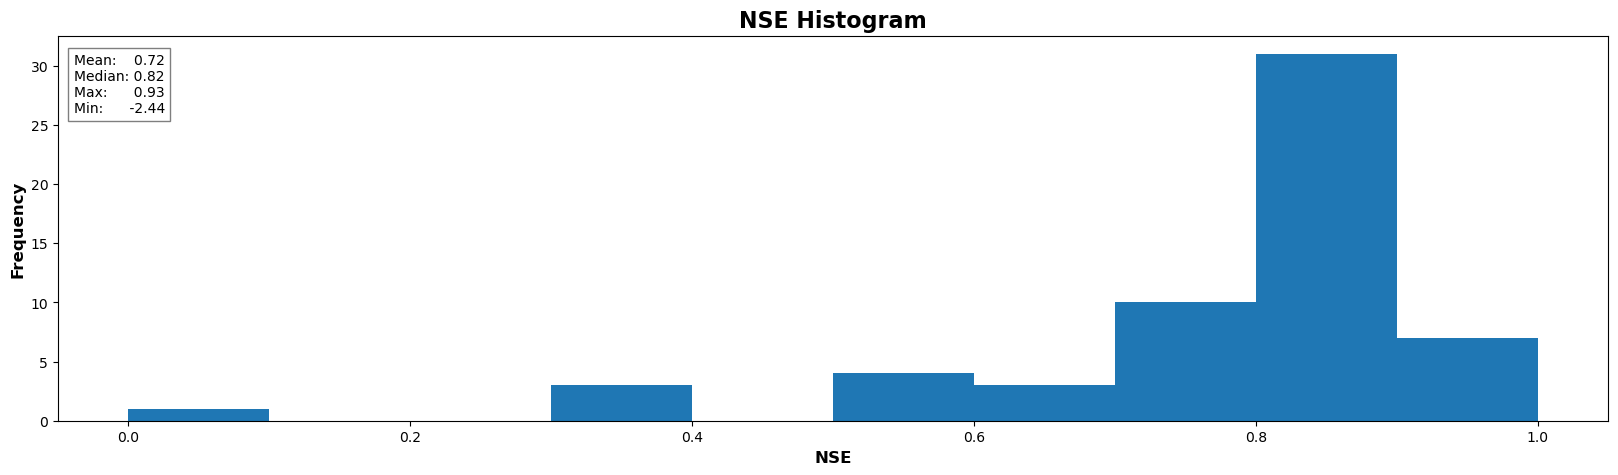

In [22]:
# Plot the histogram
plt.hist(df_NSE['NSE'], bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# Add NSE statistics to the plot
plt.text(0.01, 0.8, f'Mean: {"%.2f" % df_NSE["NSE"].mean():>7}\nMedian: {"%.2f" % df_NSE["NSE"].median():>0}\nMax: {"%.2f" % df_NSE["NSE"].max():>9}\nMin: {"%.2f" % df_NSE["NSE"].min():>10}',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel('NSE', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('NSE Histogram', fontsize=16, fontweight='bold')
#plt.savefig(save_folder+'/NSE_Histogram.png', bbox_inches='tight', pad_inches=0)
plt.show()

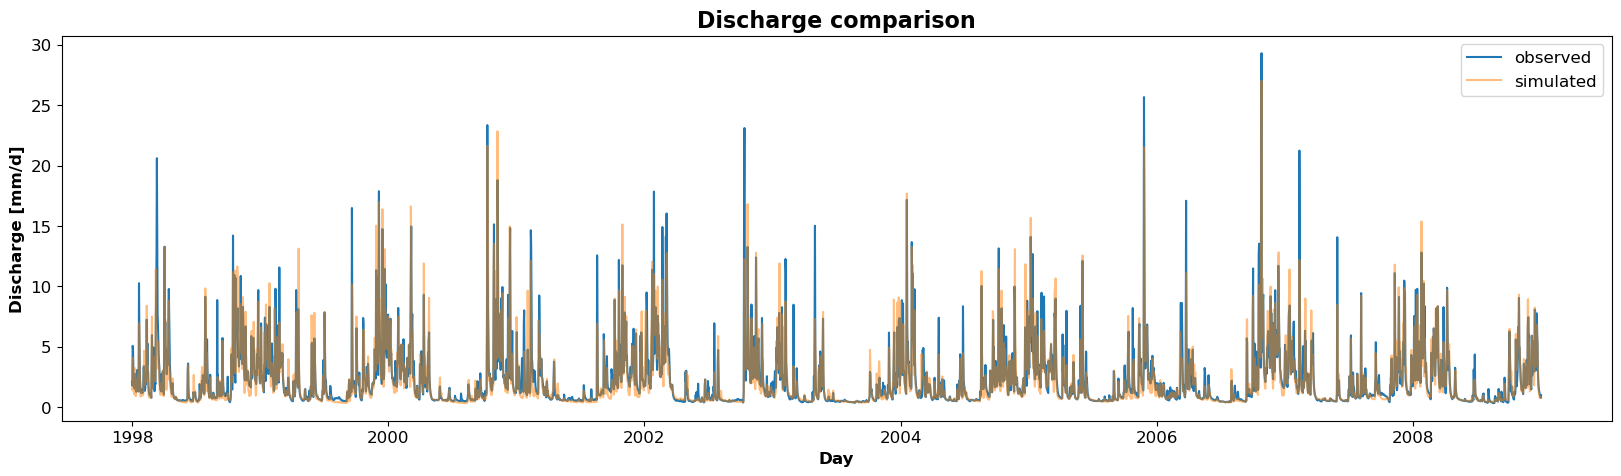

In [23]:
# Plot simulated and observed discharges
basin_to_analyze = '2001'
plt.plot(df_y_obs[basin_to_analyze], label="observed", color=color_palette["observed"])
plt.plot(df_y_sim[basin_to_analyze], label="simulated", alpha=0.5, color=color_palette["simulated"])

# Format plot
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('Discharge [mm/d]', fontsize=12, fontweight='bold')
plt.title('Discharge comparison', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right",fontsize=12)
#plt.savefig(save_folder+'/Model_Comparison.png', bbox_inches='tight', pad_inches=0)

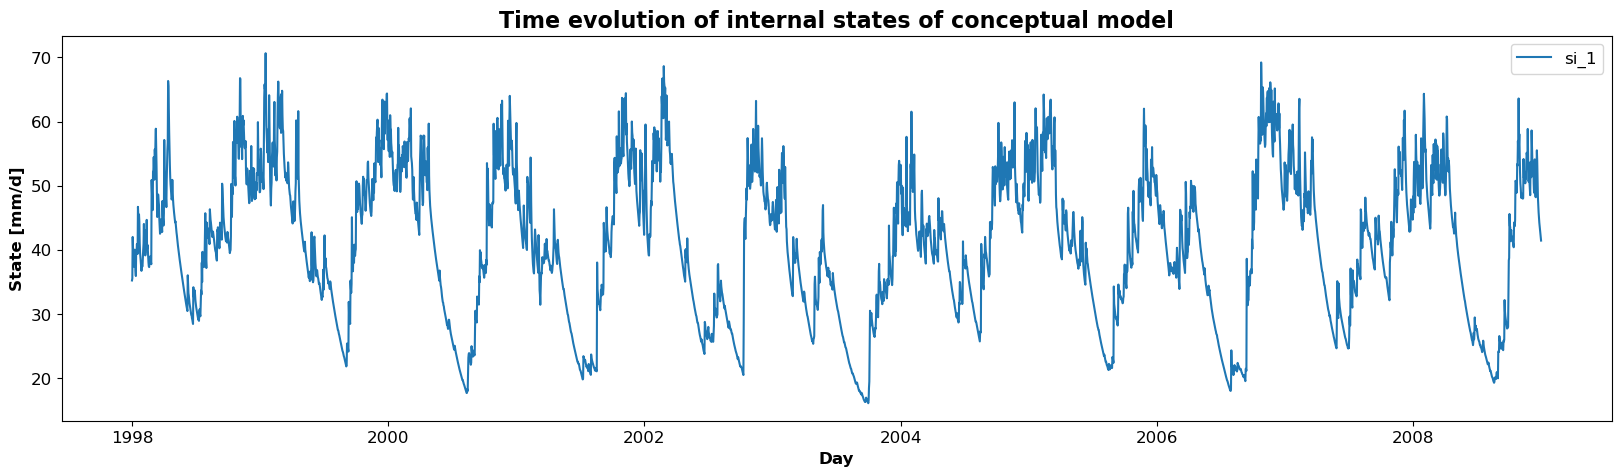

In [24]:
# Plot states
state_of_interest = 'si'

states = test_results[basin_to_analyze]['internal_states'][state_of_interest]

for i in range(states.shape[1]):
    plt.plot(df_y_obs.index, states[:, i], label=state_of_interest+'_'+str(i+1))

# Adding labels and legend
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('State [mm/d]', fontsize=12, fontweight='bold')
plt.title('Time evolution of internal states of conceptual model', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right",fontsize=12)
plt.show()

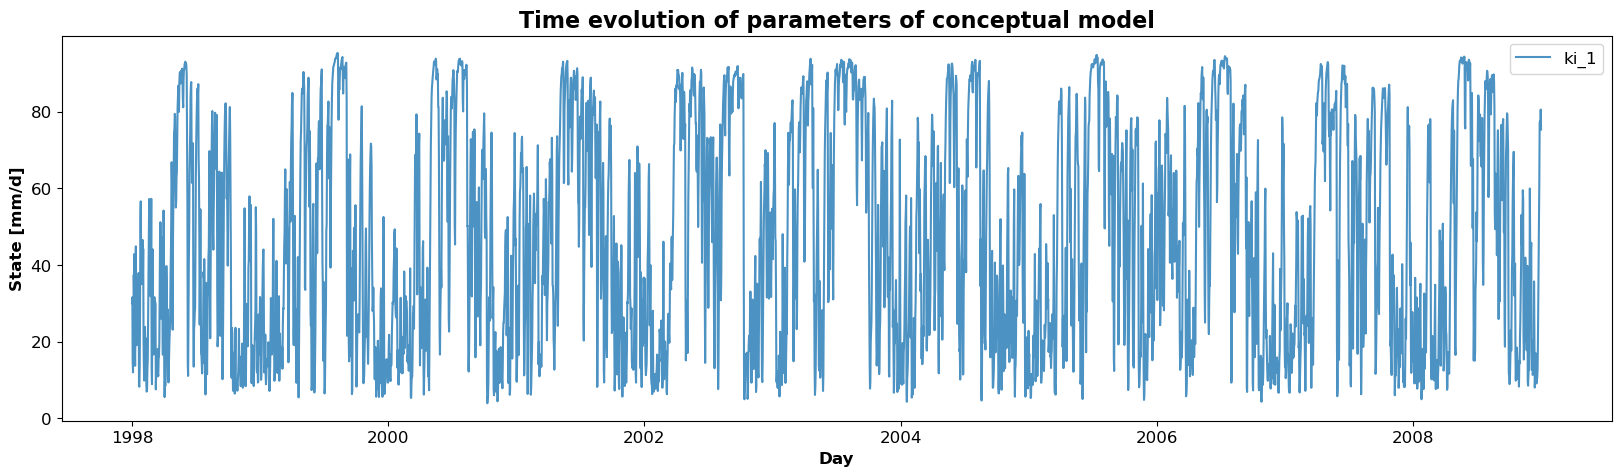

In [25]:
# Plot states
parameter_of_interest= 'ki'

states = test_results[basin_to_analyze]['parameters'][parameter_of_interest]

for i in range(states.shape[1]):
    plt.plot( df_y_obs.index, states[:, i], label=parameter_of_interest+'_'+str(i+1), alpha=0.8)

# Adding labels and legend
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('State [mm/d]', fontsize=12, fontweight='bold')
plt.title('Time evolution of parameters of conceptual model', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right",fontsize=12)
plt.show()